# AD_with_Plaques:1
# NCI_with_No_Plaques: 0

In [1]:

import tensorflow as tf
from gene_expression import *
from pathway_hierarchy import *
from utils import *
import torch

2024-08-13 14:44:45.212534: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 14:44:45.222031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 14:44:45.234410: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 14:44:45.234429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 14:44:45.243374: I tensorflow/core/platform/cpu_feature_gua

In [ ]:
import os
import torch
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import argparse
from utils import *
from gene_expression import *
from pathway_hierarchy import *
import pandas as pd
import yaml
from custom_neural_network import *
from custom_fc_network import *
from datetime import datetime
import csv
import copy
import pickle
import random
random.seed(0)
np.random.seed(0)

path_config = 'config.yml'
model_dct = dict()

# Hook function
def hook_fn(module, input, output, layer_name):
    global model_dct
    input_list = [i.detach().cpu().numpy().tolist() for i in input]
    output_list = output.detach().cpu().numpy().tolist()
    
    # If the layer name is not in the dictionary, create a new list for it
    if layer_name not in model_dct:
        model_dct[layer_name] = []

    # Append the activations to the corresponding layer list
    model_dct[layer_name].append({
        'input': input_list,
        'output': output_list
    })



# Define the file path for the CSV file
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class TabularDataset(Dataset):
    def __init__(self, count_matrix, label):
        # Read the CSV file
        self.data = count_matrix
        # Separate features and target
        self.features = self.data.values
        self.target = label.values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get features and target for a given index
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return features, target

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predicted_list = []
    probability_list = []
    labels_list = []
    criterion = nn.BCEWithLogitsLoss()
    loss = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for features, labels in dataloader:
            outputs = model(features)
            #print(outputs)
            probability = torch.sigmoid(outputs.data)
            predicted = torch.round(torch.sigmoid(outputs.data))
            #print(outputs)
            #print(predicted)
            loss += criterion(outputs, labels)
            #_, predicted = torch.sigmoid(outputs.data)
            predicted_list.extend(predicted)
            labels_list.extend(labels)
            probability_list.extend(probability)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(total)
    accuracy = 100 * correct / total
    return accuracy, loss, predicted_list, labels_list, probability_list

def save_model(model_nn,model_path, model_state_dict_path):
    
    model_nn.eval()
    torch.save(model_nn, model_path)
    torch.save(model_nn.state_dict(), model_state_dict_path)




def model_fc(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomfcNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/fc_training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            outputs = model_nn(batch_features)
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/fc_test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn



def model(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            
            
            optimizer.zero_grad()
            outputs = model_nn(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn


def load_config(config_file):
    with open(config_file, 'r') as file:
        return yaml.safe_load(file)


def main_file(path_config):

    '''parser = argparse.ArgumentParser(description='Sample application with config and argparse')
    parser.add_argument('--config', type=str, default='config.yml', help='Path to the configuration file')
    args = parser.parse_args()'''

    config = load_config(path_config)
    print(config)
    train = pd.read_csv(config['dataset']['train'],index_col=0)
    test = pd.read_csv(config['dataset']['test'],index_col=0)
    val = pd.read_csv(config['dataset']['val'],index_col=0)

    y_train = pd.read_csv(config['dataset']['y_train'])
    y_test = pd.read_csv(config['dataset']['y_test'])
    y_val = pd.read_csv(config['dataset']['y_val'])
  


    r_data_tmp = train.T
    q_data_tmp = test.T
    v_data_tmp = val.T
    r_label_tmp = y_train



    pathway_relation, ensemble_pathway_relation = return_threshold_pathways(config['pathways_network']['pathway_relation'], 
                                  config['pathways_network']['ensemble_pathway_relation'],  config['pathways_network']['h_thresh'],\
                                      config['pathways_network']['l_thresh'])

    if os.path.exists(config['pathways_network']['pathway_relation_updated']):
        os.remove(config['pathways_network']['pathway_relation_updated'])

    if os.path.exists(config['pathways_network']['ensemble_pathway_relation_updated']):
        os.remove(config['pathways_network']['ensemble_pathway_relation_updated'])

    pathway_relation.to_csv(config['pathways_network']['pathway_relation_updated'], sep = '\t', index = False, header= False)
    ensemble_pathway_relation.to_csv(config['pathways_network']['ensemble_pathway_relation_updated'], sep = '\t', index = False, header= False)




    print('Getting Marker Genes.......')
    train_x, test_x, val_x, train_y = get_expression(r_data_tmp,
                                                q_data_tmp,
                                                v_data_tmp,
                                                r_label_tmp,
                                                thrh=config['gene_expression']['highly_expressed_threshold'],
                                                thrl=config['gene_expression']['lowly_expressed_threshold'],
                                                normalization=config['gene_expression']['normalization'],
                                                marker=config['gene_expression']['marker'])
    
    print('Getting Pathway Genes.........')
    pathway_genes = get_gene_pathways(config['pathways_network']['ensemble_pathway_relation_updated'], species=config['pathways_network']['species'])


    print('Getting Masking.........')
    masking, masking_df, layers_node, train_x, test_x,val_x = get_masking(config['pathways_network']['pathway_names'],
                                                        pathway_genes,
                                                        config['pathways_network']['pathway_relation_updated'],
                                                        train_x,
                                                        test_x,
                                                        val_x,
                                                        train_y,
                                                        config['pathways_network']['datatype'],
                                                        config['pathways_network']['species'],
                                                        config['pathways_network']['n_hidden_layer'])

    test_cell_id = list(test_x.T.index) 
    try:
        masking = list(masking.values())
        layers_node = list(layers_node.values())
    except:
        print('already_done')


    train_dataset = TabularDataset(train_x.T,train_y)
    val_dataset = TabularDataset(val_x.T,y_val)
    test_dataset = TabularDataset(test_x.T,y_test)  
    
    

    dataloader_params = {
    'batch_size': config['train']['batch_size'],
    'shuffle': False
    }

    train_dataloader = DataLoader(train_dataset,**dataloader_params)
    test_dataloader = DataLoader(test_dataset, **dataloader_params)
    val_dataloader = DataLoader(val_dataset,**dataloader_params)
    # Example of iterating through the DataLoader


    pred_y_df = pd.DataFrame(data=0, index=test_x.columns, columns=list(range(2, len(masking) + 2)))
    train_y_df = pd.DataFrame(data=0, index=train_x.columns, columns=list(range(2, len(masking) + 2)))
    model_dict_sparse = dict()
    model_dict_fc = dict()
    activation_output = {}
    now = datetime.now()

# Format the date as a string
    date_string = datetime_string = now.strftime("%Y_%m_%d_%H_%M_%S")

    try:
        os.makedirs(f'{config['model_output']['model_save_dir']}{date_string}')
    except:
        print(('...'))

   

    print('Training.........')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_sparse[output_layer] = model(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  

    print('tranining_fully_connected_layers:')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_fc[output_layer] = model_fc(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  
        
    new_parameter = {'date_string': date_string}
    config.update(new_parameter)
    save_path =   str(config['model_output']['model_save_dir'])+ date_string + '/config.yml'
    with open(save_path, 'w') as file:
        yaml.dump(config, file)

        
    for i in range(len(masking_df)):
        masking_df[i].to_csv(str(config['model_output']['model_save_dir'])+ date_string+ '/' +f'masking_df_{i}.csv')
    
   
        
    return model_dict_sparse, val_dataloader, test_dataloader, train_dataloader, train_x, train_y, val_x, y_val, test_x, y_test, config

   
model_dict_sparse, val_dataloader, test_dataloader, train_dataloader,train_x, train_y, val_x, y_val, test_x, y_test, config = main_file(path_config= path_config)
for j,i in model_dict_sparse.items():

# Assuming 'model' is your neural network
    torch.save(i.state_dict(), f'{config['model_output']['model_save_dir']}{config['date_string']}/model_{j}_state_dict_jupyter_notebook.pth')


for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}') 

{'dataset': {'train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv', 'test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv', 'val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv', 'y_train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv', 'y_test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv', 'y_val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'}, 'model_output': {'model_save_dir': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excito

In [ ]:

train_dataset = TabularDataset(train_x.T,train_y)
val_dataset = TabularDataset(val_x.T,y_val)
test_dataset = TabularDataset(test_x.T,y_test) 

dataloader_params = {
    'batch_size': 1,
    'shuffle': False
    }

train_dataloader = DataLoader(train_dataset,**dataloader_params)
test_dataloader = DataLoader(test_dataset, **dataloader_params)
val_dataloader = DataLoader(val_dataset,**dataloader_params)

for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}')

In [5]:
config

{'dataset': {'train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv',
  'test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv',
  'val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv',
  'y_train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv',
  'y_test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv',
  'y_val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'},
 'model_output': {'model_save_dir': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_

In [6]:
config['model_output']['model_save_dir'] 

'/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/'

In [7]:
train_x

cell_id,GTACAACAGGCGTTGA.21.11,GAGTTGTAGCAACAGC.42.2,ACACCAATCCCGATCT.23.6,GCACATAAGAATCTAG.10.7,AAGACCTAGCCTATGT.13.1,ACTTACTGTCAGAAGC.8.1,CACAGGCAGAATCTCC.38.1,CGAGCCAGTATTACCG.29.0,ACCCAAAGTGACCTGC.1.5,CGGACGTTCATGTGGT.15.1,...,AGGGCCTTCGAGAACG.12.14,GCGATCGCACCTCTAC.12.11,ATGTCTTGTTCACCGG.16.2,TGCAGTACAACCAATC.26.2,CGGACGTCACGGTAGA.19.0,CTAACCCTCCCGGTAG.31.6,TCGGGCATCCCAGTGG.12.14,ATCACGAGTATCACCA.6.2,AAGACTCGTTGGGTAG.10.7,GATGATCCAGCCATTA.30.6
ENSG00000228716,0.000000,0.000000,0.000000,1.143541,0.0000,0.000000,0.000000,0.000000,1.420167,0.0,...,2.093010,1.060421,0.000000,0.360711,0.000000,0.000000,1.351873,0.501618,0.656484,0.454942
ENSG00000030066,0.000000,0.000000,0.835170,0.381069,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,...,1.786504,0.000000,0.000000,0.360711,1.012347,3.310814,0.000000,0.000000,0.000000,0.454942
ENSG00000087460,2.814551,2.213542,2.697879,2.387443,3.4106,2.391544,0.000000,0.000000,2.865052,0.0,...,2.913176,2.557026,1.909814,2.044270,1.601402,1.990744,3.253745,0.501618,2.984559,1.689015
ENSG00000149313,0.000000,0.000000,1.360721,0.000000,0.0000,0.000000,0.000000,0.000000,0.878202,0.0,...,0.000000,0.000000,0.940507,0.360711,0.000000,0.000000,0.000000,0.501618,1.956495,0.454942
ENSG00000160991,0.000000,0.000000,0.000000,0.682226,0.0000,0.000000,2.347186,0.000000,1.420167,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000141337,0.000000,0.000000,0.835170,0.381069,0.0000,0.000000,0.000000,0.000000,0.504917,0.0,...,0.000000,0.000000,0.000000,0.360711,0.000000,0.000000,0.828808,0.000000,0.000000,0.800293
ENSG00000102468,0.000000,0.000000,0.000000,1.328568,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,1.394136,0.000000,0.360711,0.000000,0.000000,0.000000,1.168258,2.629036,1.078734
ENSG00000185518,3.329483,2.213542,2.298758,2.545204,0.0000,2.881817,4.117132,2.382166,3.411148,0.0,...,2.560607,1.394136,1.909814,2.857840,3.191803,3.310814,1.734937,2.113168,2.331606,2.445920
ENSG00000168539,0.000000,0.000000,0.000000,0.381069,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.625523,0.000000,0.649033,0.000000,0.000000,0.000000,0.000000,0.656484,0.000000


In [8]:
model_dict_sparse

{2: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=174, out_features=247, bias=False)
     (1): Linear(in_features=247, out_features=1, bias=True)
   )
 ),
 3: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=174, out_features=247, bias=False)
     (1): Linear(in_features=247, out_features=226, bias=False)
     (2): Linear(in_features=226, out_features=1, bias=True)
   )
 ),
 4: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=174, out_features=247, bias=False)
     (1): Linear(in_features=247, out_features=226, bias=False)
     (2): Linear(in_features=226, out_features=153, bias=False)
     (3): Linear(in_features=153, out_features=1, bias=True)
   )
 )}

In [9]:
model_dict_sparse[2]

CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=174, out_features=247, bias=False)
    (1): Linear(in_features=247, out_features=1, bias=True)
  )
)

In [10]:
accuracy, loss, predicted_list, labels_list, probability_list = evaluate(model_dict_sparse[2], test_dataloader)
accuracy

66.69505962521295

In [11]:
for features, labels in test_dataloader:
    print(labels)
    print(features.shape)
    break

tensor([[1.]])
torch.Size([1, 174])


In [12]:
config

{'dataset': {'train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv',
  'test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv',
  'val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv',
  'y_train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv',
  'y_test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv',
  'y_val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'},
 'model_output': {'model_save_dir': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_

# Result Analysis

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_matrix_return(result):
    cm = confusion_matrix(result['true_y'], result['pred_y'])
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

def roc_curve_return(result):
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(result['true_y'], result['probabilty'])
    
    # Calculate the AUC
    auc = roc_auc_score(result['true_y'], result['probabilty'])
    print(f'AUC: {auc}')
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [15]:


import pandas as pd
from sklearn.metrics import precision_score

# Sample DataFrame
def return_accuracy(result):
    df = result.copy()
    
    # Calculate positive accuracy (precision for positive class)
    positive_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=1)
    
    # Calculate negative accuracy (precision for negative class)
    negative_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=0)
    
    print(f'Positive Accuracy (Precision for positive class): {positive_accuracy}')
    print(f'Negative Accuracy (Precision for negative class): {negative_accuracy}')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 1


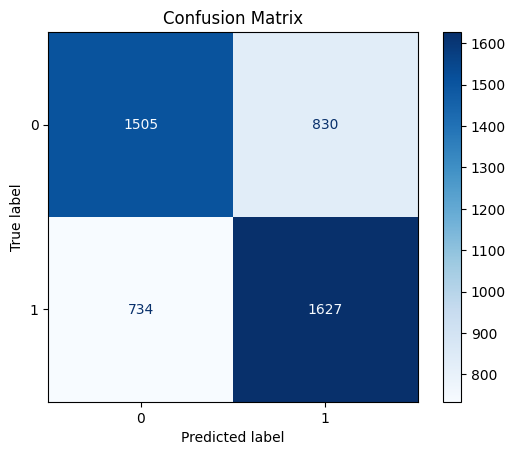

AUC: 0.7183289844701598


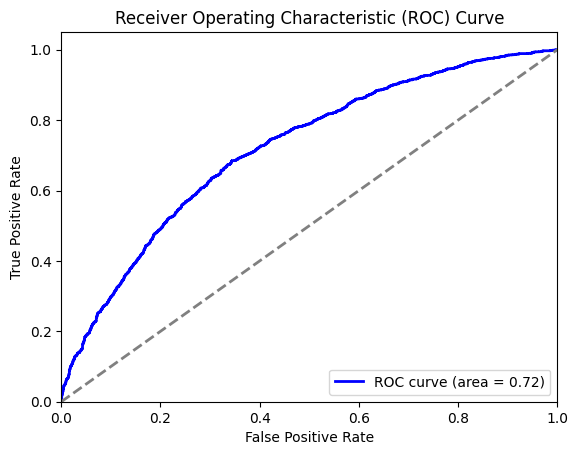

Positive Accuracy (Precision for positive class): 0.6621896621896622
Negative Accuracy (Precision for negative class): 0.6721750781598929
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 2


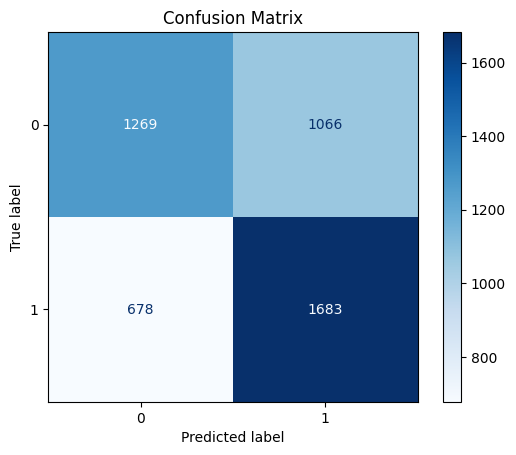

AUC: 0.6779085913401846


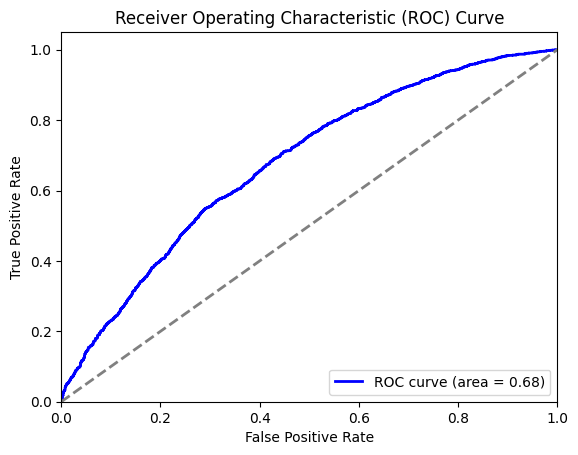

Positive Accuracy (Precision for positive class): 0.6122226264096035
Negative Accuracy (Precision for negative class): 0.6517719568567026
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 3


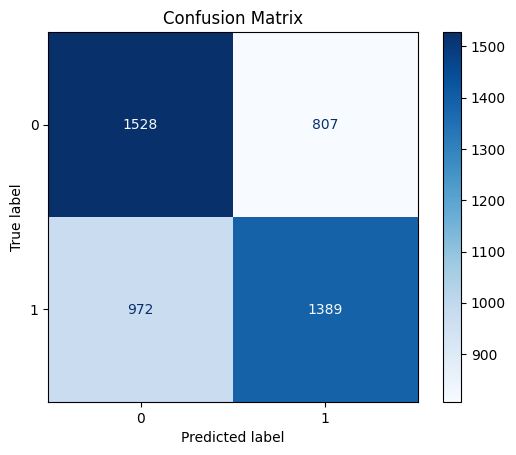

AUC: 0.6713020378437257


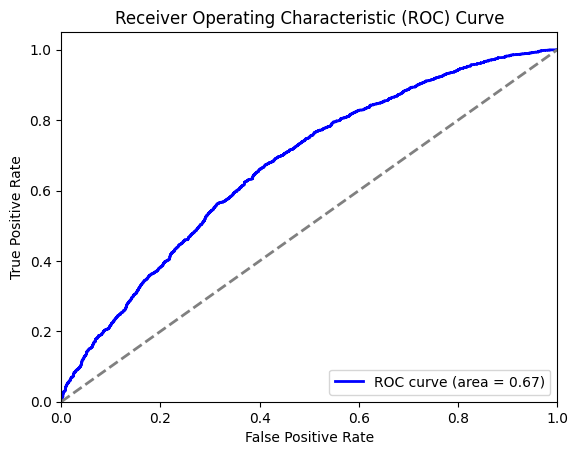

Positive Accuracy (Precision for positive class): 0.6325136612021858
Negative Accuracy (Precision for negative class): 0.6112


In [16]:
dir_path = config['model_output']['model_save_dir'] + config['date_string']+ '/' + 'test_log_'

for i in range(2,config['pathways_network']['n_hidden_layer']+2):
    print('-'*282)
    print(f'Number of Hidden Layers: {i-1}')
    result = pd.read_csv(f'{dir_path}{i}.csv',index_col=0)

    confusion_matrix_return(result)
    roc_curve_return(result)
    return_accuracy(result)

# Model Interpretation

In [17]:
# Define a hook function to capture the activations


def get_activation(name, number_of_layers, config, activations):
    def hook(model, input, output):
        # Convert output to numpy array for easier handling, but this is optional
        activations[name] = output.detach().numpy()
        
           
    return hook
def attaching_hook(model, dataloader):
    
        correct = 0
        total = 0
        predicted_list = []
        probability_list = []
        labels_list = []
        activations_list = []
        features_list = []
        criterion = nn.BCEWithLogitsLoss()
        loss = 0
        

        with torch.no_grad():  # No need to compute gradients during evaluation
            for sample_idx, (features, labels) in tqdm(enumerate(dataloader)):
                
                
                #print(labels)
                #print(features.shape)
                activations = {}
                for idx, layer in enumerate(model.layers):
                    layer_name = f'layer_{idx}'
                    number_of_layers = len(model.layers)
                    activation_hook = get_activation(layer_name, number_of_layers, config, activations)
                    
                    layer.register_forward_hook(activation_hook)
    
                outputs =  model(features)
                    #print(outputs)
                probability = torch.sigmoid(outputs.data)
                predicted = torch.round(torch.sigmoid(outputs.data))
                    #print(outputs)
                    #print(predicted)
                #loss += criterion(outputs, labels)
                    #_, predicted = torch.sigmoid(outputs.data)
                predicted_list.extend(predicted.detach().numpy())
                labels_list.extend(labels.detach().numpy())
                probability_list.extend(probability.detach().numpy())
                features_list.append(features)
                total += labels.size(0)
                x = activations
                activations_temp = activations.copy()
                activations_list.append(activations_temp)
                
                correct += (predicted == labels).sum().item()
                '''if sample_idx == 1000:
                    #print(activations_list)
                    break'''
                
            #print(total)
        accuracy = 100 * correct / total
        #print(activations_list)
        return activations_list, accuracy, predicted_list, labels_list, features_list,x
        


In [18]:

def return_feature_importance(model_dict_sparse, dataloader):
    predicted_list_dict = {}
    ground_truth_list_dict = {}
    activations_list_dict = {}
    accuracy_list_dict = {}
    for i, j in model_dict_sparse.items():
        #accuracy, loss, predicted_list, labels_list, probability_list = evaluate(j, dataloader)
        
        activations_list_dict[f'model_{i}_hidden_layers'], accuracy_list_dict[f'model_{i}_hidden_layers'], \
        predicted_list_dict[f'model_{i}_hidden_layers'], ground_truth_list_dict[f'model_{i}_hidden_layers'], \
        feature_list,x= attaching_hook(j, dataloader)
        print(f'{i} Layers: {accuracy_list_dict[f'model_{i}_hidden_layers']}')
        
    return activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x

In [19]:

activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x = return_feature_importance(model_dict_sparse, test_dataloader)

4696it [00:35, 130.83it/s]


2 Layers: 66.69505962521295


4696it [00:56, 82.91it/s] 


3 Layers: 62.86201022146508


4696it [01:20, 58.58it/s] 

4 Layers: 62.116695059625215


In [20]:
def return_feature_importance_list(activations_list_dict, model_name):
    m=0
    for k in tqdm(activations_list_dict[model_name]):
        #print(k)
        if m == 0:
            layer_dict = {key: [] for key in list(k.keys())}
        m = m+1
        
        #print(k['0_layer_0'])
        for z in list(layer_dict.keys()):
            #print(k)
            layer_dict[z].append(k[z][0])

    return layer_dict
    

In [21]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_2_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))
    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])
layer_0_df

li = []
for i in layer_dict['layer_1']:
    li.append(list(i))
    
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 862819.85it/s]


In [23]:
layer_0_df

,R-HSA-3315487,R-HSA-3656532,R-HSA-209560_copy1,R-HSA-5205685_copy1,R-HSA-9032759_copy1,R-HSA-2514859_copy1,R-HSA-5358747,R-HSA-1971475_copy1,R-HSA-73776_copy1,R-HSA-159227_copy1,...,R-HSA-141430_copy1,R-HSA-9635465,R-HSA-389960_copy1,R-HSA-114508_copy2,R-HSA-9013419_copy1,R-HSA-2161541_copy1,R-HSA-6788467_copy1,R-HSA-3560801_copy1,R-HSA-8875555_copy1,R-HSA-416993
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,-0.104177,0.128060,0.010123,0.171800,0.378658,-0.086698,0.091002,-0.201550,0.261269,-0.081268,...,-0.191488,0.183320,-0.222688,0.238013,-0.061297,-0.146795,0.248670,-0.127721,0.462251,-0.377998
AGCTTCCGTCTCTCTG.9.9,0.000000,0.182171,0.000000,-0.176692,0.246327,0.090808,0.050610,-0.299075,0.129498,0.000000,...,0.000000,0.148118,-0.112575,0.702499,0.000000,0.000000,0.355612,-0.234067,0.169219,-0.423348
CGCCAGACAACAAGTA.17.11,-0.120349,0.228286,0.071449,0.011055,0.518755,-0.014310,0.083217,-0.186013,0.227450,-0.122589,...,0.000000,0.225380,-0.098334,0.302307,0.000000,-0.116238,0.225101,-0.162024,0.236334,-0.384918
GGGATGATCGTAACAC.7.4,-0.186852,0.068468,-0.056526,-0.028001,0.518847,0.015822,0.088915,-0.159729,0.074406,0.000000,...,-0.115525,0.229217,-0.155028,0.542527,-0.065121,0.000000,0.000000,-0.259453,0.297295,-0.190980
ACGTTCCGTATTCTCT.5.11,0.000000,0.000000,0.000000,0.354219,0.000000,0.000000,0.000000,-0.191324,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.299068,0.000000,-0.592075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.000000,0.000000,0.149445,0.217579,0.438324,0.043964,0.059833,-0.162424,-0.391722,0.000000,...,-0.104156,0.327104,-0.248611,0.653575,0.000000,0.000000,0.000000,-0.263830,0.000000,-0.280876
GTCAGCGGTCTGATAC.45.2,-0.250623,0.000000,-0.057824,-0.073373,0.379557,0.123249,-0.015392,-0.067214,-0.040238,0.000000,...,0.000000,0.404054,-0.270675,0.303669,0.000000,0.000000,0.241985,0.105066,0.342795,-0.309141
CATGCTCAGTGTCATC.30.10,0.000000,0.071860,-0.044960,-0.163976,0.383798,0.009163,0.044208,-0.066473,0.181265,0.000000,...,0.000000,0.199733,-0.076705,-0.109112,0.000000,-0.082373,0.245705,-0.107975,0.359899,-0.291026


In [25]:
last_layer_df

,last_layer
cell_id,
CACAACATCGTCCTTG.26.2,0.219095
AGCTTCCGTCTCTCTG.9.9,-0.219352
CGCCAGACAACAAGTA.17.11,-0.233183
GGGATGATCGTAACAC.7.4,0.532885
ACGTTCCGTATTCTCT.5.11,-0.003342
...,...
CATCAAGTCCTCGCAT.19.1,-1.132989
GTCAGCGGTCTGATAC.45.2,0.942101
CATGCTCAGTGTCATC.30.10,0.784364


In [26]:
layer_1_df

NameError: name 'layer_1_df' is not defined

In [27]:
last_layer_df

,last_layer
cell_id,
CACAACATCGTCCTTG.26.2,0.219095
AGCTTCCGTCTCTCTG.9.9,-0.219352
CGCCAGACAACAAGTA.17.11,-0.233183
GGGATGATCGTAACAC.7.4,0.532885
ACGTTCCGTATTCTCT.5.11,-0.003342
...,...
CATCAAGTCCTCGCAT.19.1,-1.132989
GTCAGCGGTCTGATAC.45.2,0.942101
CATGCTCAGTGTCATC.30.10,0.784364


In [28]:
y_test

,diagnosis
0,1
1,0
2,0
3,1
4,1
...,...
4691,1
4692,1
4693,1
4694,0


In [29]:
for i,j in predicted_list_dict.items():
    flattened_list = [item for sublist in list(predicted_list_dict[i]) for item in sublist]
    predicted_list_dict[i] = flattened_list
    

In [30]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]

In [31]:
predicted_list_dict['model_4_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]

In [32]:
for i,j in ground_truth_list_dict.items():
    flattened_list = [item for sublist in list(ground_truth_list_dict[i]) for item in sublist]
    ground_truth_list_dict[i] = flattened_list
    

In [33]:
ground_truth_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [34]:
ground_truth_list_dict['model_4_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [35]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]

In [36]:
layer_1_df['predicted'] = predicted_list_dict['model_2_hidden_layers']
layer_1_df['ground_truth'] = ground_truth_list_dict['model_2_hidden_layers']
layer_1_df.head()

NameError: name 'layer_1_df' is not defined

In [37]:
correct_predicted_layer_1_df = layer_1_df[layer_1_df.predicted == layer_1_df.ground_truth]
correct_predicted_layer_1_df_AD = correct_predicted_layer_1_df[correct_predicted_layer_1_df.predicted == 1]
correct_predicted_layer_1_df_Control = correct_predicted_layer_1_df[correct_predicted_layer_1_df.predicted == 0]

NameError: name 'layer_1_df' is not defined

In [38]:
correct_predicted_layer_1_df_AD.drop(columns=['predicted','ground_truth'], inplace = True)
correct_predicted_layer_1_df_AD.head()

NameError: name 'correct_predicted_layer_1_df_AD' is not defined

In [39]:
correct_predicted_layer_1_df_Control.drop(columns=['predicted','ground_truth'], inplace = True)
correct_predicted_layer_1_df_Control

NameError: name 'correct_predicted_layer_1_df_Control' is not defined

In [40]:
from scipy import stats



# Perform a two-sample t-test





In [41]:
pathways_list = []
p_value_list = []

for i in correct_predicted_layer_1_df_Control.columns:
    t_stat, p_value = stats.ttest_ind(correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist())
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

    plt.figure(figsize=(8, 6))
    plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True, 
                boxprops=dict(facecolor='lightblue'))
    
    # Add title and labels
    plt.title('Box Plot of Two Distributions')
    plt.ylabel('Values')
    pathways_list.append(i)
    p_value_list.append(p_value)
    # Display the plot
    plt.show()
    
    

NameError: name 'correct_predicted_layer_1_df_Control' is not defined

In [42]:
pd.DataFrame(pathways_list, p_value_list)

""


In [43]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_3_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 554142.80it/s]


In [44]:
layer_1_df

,R-HSA-417957,R-HSA-162592,R-HSA-5654689,R-HSA-75896,R-HSA-5654716,R-HSA-159231,R-HSA-5210891,R-HSA-113507,R-HSA-5339716,R-HSA-9034864,...,R-HSA-5655291_copy1,R-HSA-5654688,R-HSA-6783310_copy1,R-HSA-5675482,R-HSA-9027604,R-HSA-5661231,R-HSA-2979096,R-HSA-901042,R-HSA-9665348,R-HSA-77288
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,0.003275,0.009810,-0.015456,0.000000,0.001502,0.001915,0.009021,-0.010476,-0.006433,-0.000057,...,0.027487,0.000277,0.002091,-0.000094,0.000000,0.000000,0.012869,-0.000795,0.011302,-0.000602
AGCTTCCGTCTCTCTG.9.9,0.000000,0.012895,-0.005234,0.000000,-0.003001,0.000000,0.010151,-0.005489,-0.002985,0.000000,...,0.008764,0.000000,0.000000,0.000000,0.000000,0.000000,0.023016,0.000000,0.000332,0.000000
CGCCAGACAACAAGTA.17.11,0.000000,0.013725,-0.010916,0.000000,-0.001140,0.006392,0.008776,-0.012376,-0.004896,-0.000100,...,0.023170,-0.000132,0.005502,0.003574,-0.000662,0.000000,0.011449,-0.001674,0.009848,-0.000389
GGGATGATCGTAACAC.7.4,0.000000,0.007576,-0.009176,-0.003849,0.012905,0.000000,0.014573,0.000000,-0.005228,-0.000047,...,0.016054,0.000687,0.004162,-0.004238,0.000000,0.000000,0.016451,0.000013,0.015558,0.000000
ACGTTCCGTATTCTCT.5.11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034737,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.012875,0.000000,0.000000,0.000000,0.000000,0.000000,0.006510,-0.006484,-0.003527,0.000000,...,0.000000,0.000000,0.009876,0.006180,0.000000,0.000000,0.003763,-0.004656,0.000000,-0.001288
GTCAGCGGTCTGATAC.45.2,0.000000,0.025255,-0.016036,0.000000,-0.005883,0.000000,0.013536,-0.007280,-0.001409,-0.000141,...,0.033405,-0.000373,-0.001616,-0.004335,0.000000,0.000069,0.016819,0.000014,0.011218,0.000000
CATGCTCAGTGTCATC.30.10,0.000000,0.020581,-0.013634,0.000000,-0.011415,0.000000,0.013967,-0.013448,-0.003815,-0.000052,...,0.025742,-0.000368,0.000013,-0.003372,0.000000,0.000000,0.008851,0.000011,0.001313,0.000000


In [45]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_4_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i)) 
layer_2_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_2'])

li = []
for i in layer_dict['layer_3']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 443773.69it/s]


In [46]:
layer_2_df

,R-HSA-5655332,R-HSA-5693537,R-HSA-5205647,R-HSA-881907,R-HSA-2660825,R-HSA-5654696,R-HSA-109704,R-HSA-198753,R-HSA-211976,R-HSA-5654687,...,R-HSA-389356,R-HSA-8979227,R-HSA-446353,R-HSA-196807,R-HSA-1181150,R-HSA-1839124,R-HSA-6804758,R-HSA-3371571,R-HSA-5260271,R-HSA-8963898
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,-0.003298,-0.000165,-0.001825,-0.000286,0.001378,-0.003232,0.001074,-0.000682,0.000001,0.000799,...,0.000024,0.001375,0.000942,-0.000680,-0.000505,-0.000043,0.000042,-0.000133,0.002777,0.004619
AGCTTCCGTCTCTCTG.9.9,-0.001275,-0.000542,0.003747,0.000000,0.002781,-0.001038,0.000221,-0.000620,0.000007,0.000482,...,0.000059,0.000580,0.001331,-0.000299,-0.000403,-0.000027,0.000000,-0.000133,0.004294,0.001991
CGCCAGACAACAAGTA.17.11,-0.002072,-0.000194,-0.000583,0.000020,0.001338,-0.003624,0.000773,-0.000940,0.000005,0.000524,...,-0.000422,0.001126,0.001401,-0.000515,-0.000350,-0.000085,0.000048,-0.000117,0.003689,0.003816
GGGATGATCGTAACAC.7.4,-0.001756,-0.000536,0.001314,-0.000621,0.001628,-0.001184,0.001733,-0.000956,0.000010,-0.000068,...,0.000212,0.001284,0.001769,-0.000462,-0.000622,-0.000023,0.000000,-0.000158,0.002709,0.004330
ACGTTCCGTATTCTCT.5.11,0.000000,0.000000,-0.004301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000240,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.000000,-0.000968,-0.004846,0.000000,0.000000,0.000000,0.000000,-0.001352,0.000008,0.000000,...,0.000000,0.001268,0.001014,-0.000750,0.000000,-0.000026,0.000000,0.000000,0.003127,0.004278
GTCAGCGGTCTGATAC.45.2,-0.003111,0.000000,0.003738,0.000186,0.001664,-0.005484,0.000576,-0.001488,0.000012,0.000944,...,-0.000818,0.000000,0.000000,-0.000397,-0.000792,-0.000100,0.000000,-0.000109,0.002332,0.000000
CATGCTCAGTGTCATC.30.10,-0.003066,-0.000559,0.005367,0.000263,0.000776,-0.003960,0.001311,-0.000742,0.000011,0.001265,...,-0.000353,0.001623,0.001542,-0.000403,-0.000563,-0.000065,0.000028,-0.000110,0.000000,0.005398


# layer_2_df

# Plots

In [782]:
!pwd

/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network
